In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pymysql
import seaborn as sns

from scipy.stats import norm, skew, kurtosis, shapiro
from statsmodels.tsa.stattools import adfuller, coint
from scipy.linalg import toeplitz

In [2]:
conn = pymysql.connect(
    host="192.168.7.93",
    user="quantchina",
    password="zMxq7VNYJljTFIQ8",
    database="wind",
    charset="gbk"
)

cursor = conn.cursor()
code = ['000300.SH', '399852.SZ']
df_dict = {}

for i in range(len(code)):
    query = """
        SELECT TRADE_DT, S_DQ_CLOSE 
        FROM AINDEXEODPRICES 
        WHERE S_INFO_WINDCODE='{ticker}' and TRADE_DT BETWEEN '20140101' AND '20231231' 
        ORDER BY TRADE_DT
    """.format(ticker=code[i])
    cursor.execute(query)

    data = cursor.fetchall()
    df = pd.DataFrame(data, columns=['date','prices'])
    df.set_index('date', inplace=True)
    df_dict[code[i]] = df.astype(float)

df = pd.concat([df_dict['000300.SH'], df_dict['399852.SZ']], axis=1)
df.columns = ['000300.SH', '399852.SZ']
df['ratio'] = (df['399852.SZ'] / df['000300.SH']).astype(float)
df['mean'] = df.ratio.rolling(window=242).mean()
df['rate'] = df.ratio.pct_change()

cursor.close()
conn.close()

In [5]:
# df.to_excel('配对交易.xlsx', index=True)
df[['000300.SH', '399852.SZ']].corr()

,000300.SH,399852.SZ
000300.SH,1.000000,0.311843
399852.SZ,0.311843,1.000000


In [6]:
# 两序列单整检验 #
res1 = adfuller(df['000300.SH'])
res2 = adfuller(df['399852.SZ'])
print("沪深300的单位根检验p值：", res1[1])
print("中证1000的单位根检验p值：", res2[1])

沪深300的单位根检验p值： 0.1310596639165933
中证1000的单位根检验p值： 0.10839850785098598


In [7]:
diff_hs = df['000300.SH'].diff()[1:]
diff_zz = df['399852.SZ'].diff()[1:]

res1_diff = adfuller(diff_hs)
res2_diff = adfuller(diff_zz)
print(res1_diff[1])
print(res2_diff[1])

1.7911975286268008e-14
8.471386443768468e-20


In [8]:
# 协整检验 #
result_coint = coint(df['000300.SH'], df['399852.SZ'])
print("沪深300与中证1000协整检验p值：", result_coint[1])

沪深300与中证1000协整检验p值： 0.5298747471041232


In [9]:
X = df['000300.SH'].to_numpy()
y = df['399852.SZ'].to_numpy()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
residuals = results.resid
print("残差项平稳性检验：", adfuller(residuals))

残差项平稳性检验的结果： (-2.119146921995207, 0.23688554873795947, 27, 2406, {'1%': -3.4330708189719914, '5%': -2.862742022728184, '10%': -2.567409886740616}, 29332.245351332578)


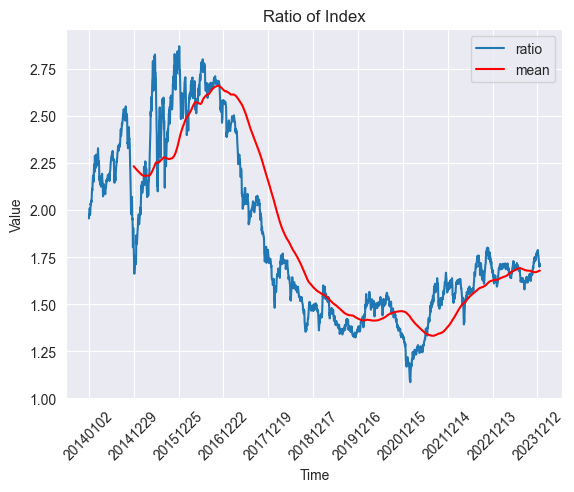

In [10]:
# 十年滚动均值 #
plt.plot(df.index, df['ratio'], label='ratio')
plt.plot(df.index, df['mean'], color='red', label='mean')
plt.xticks(df.index[::242], df.index[::242])
plt.xticks(rotation=45)
plt.title('Ratio of Index')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

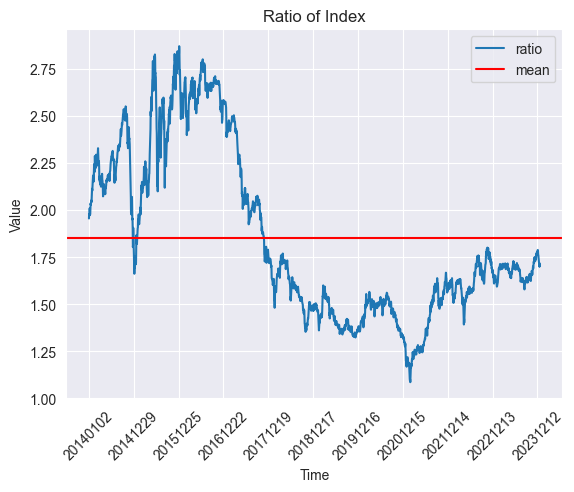

In [11]:
# 十年固定均值 #
plt.plot(df.index, df['ratio'], label='ratio')
plt.axhline(df['ratio'].mean(), color='red', label='mean')
plt.xticks(df.index[::242], df.index[::242])
plt.xticks(rotation=45)
plt.title('Ratio of Index')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [12]:
def eda(arr):
    stat_list = [np.mean(arr), np.std(arr), skew(arr), kurtosis(arr)]
    statistics, p_value = shapiro(arr)
    stat_list = stat_list + [round(p_value, 3)]
    return np.array(stat_list).reshape([1, 5])

tbl = pd.DataFrame(eda(df['ratio']), 
                   columns=['mean', 'std', 'skew', 'kurtosis', 'p_value'], 
                   index=['ratio'])
print(tbl)

           mean       std     skew  kurtosis  p_value
ratio  1.852934  0.452869  0.63252 -0.925004      0.0


In [13]:
after = df.loc["20171201":, ['ratio', 'mean']]
after['rate'] = df.ratio.pct_change().loc["20171201":]
after['mean3'] = df.ratio.rolling(window=726).mean().loc['20171201':]

In [14]:
after.head()

,ratio,mean,rate,mean3
date,,,,
20171201,1.804785,2.189414,0.010704,2.385916
20171204,1.776562,2.186092,-0.015638,2.385539
20171205,1.719372,2.182581,-0.032191,2.385057
20171206,1.747280,2.179297,0.016231,2.384697
20171207,1.765955,2.176416,0.010688,2.384444


In [15]:
result_coint = coint(df.loc['20171201':, '000300.SH'], df.loc['20171201':, '399852.SZ'])
print("后半部分协整检验p值：", result_coint[1])

后半部分协整检验p值： 0.5439110971829078


In [16]:
df.loc['20171201':, ['000300.SH', '399852.SZ']].corr()

,000300.SH,399852.SZ
000300.SH,1.000000,0.716992
399852.SZ,0.716992,1.000000


In [17]:
# Function to extract cycle using HP filter
def extract_cycle(y, lamb=1600):
    def diff2(n):
        col = np.zeros(n-2)
        col[0] = 1
        row = np.zeros(n)
        row[:3] = [1, -2, 1]
        return toeplitz(col, row)
    T = len(y)
    D = diff2(T)
    trend = np.linalg.inv(np.eye(T) + lamb * D.T @ D) @ y
    cycle = y - trend
    return cycle

# Apply HP filter to extract cycle
y1, y2 = df.loc['20171201':, '000300.SH'], df.loc['20171201':, '399852.SZ']
cycle1 = extract_cycle(y1, 129600)
cycle2 = extract_cycle(y2, 129600)

result = coint(cycle1, cycle2)
print("Cointegration Test Results:")
print("Test Statistic:", result[0])
print("P-value:", result[1])
print("Critical Values:", result[2])

Cointegration Test Results:
Test Statistic: -9.115750310521689
P-value: 4.404297867276151e-14
Critical Values: [-3.90387033 -3.34026996 -3.04732274]


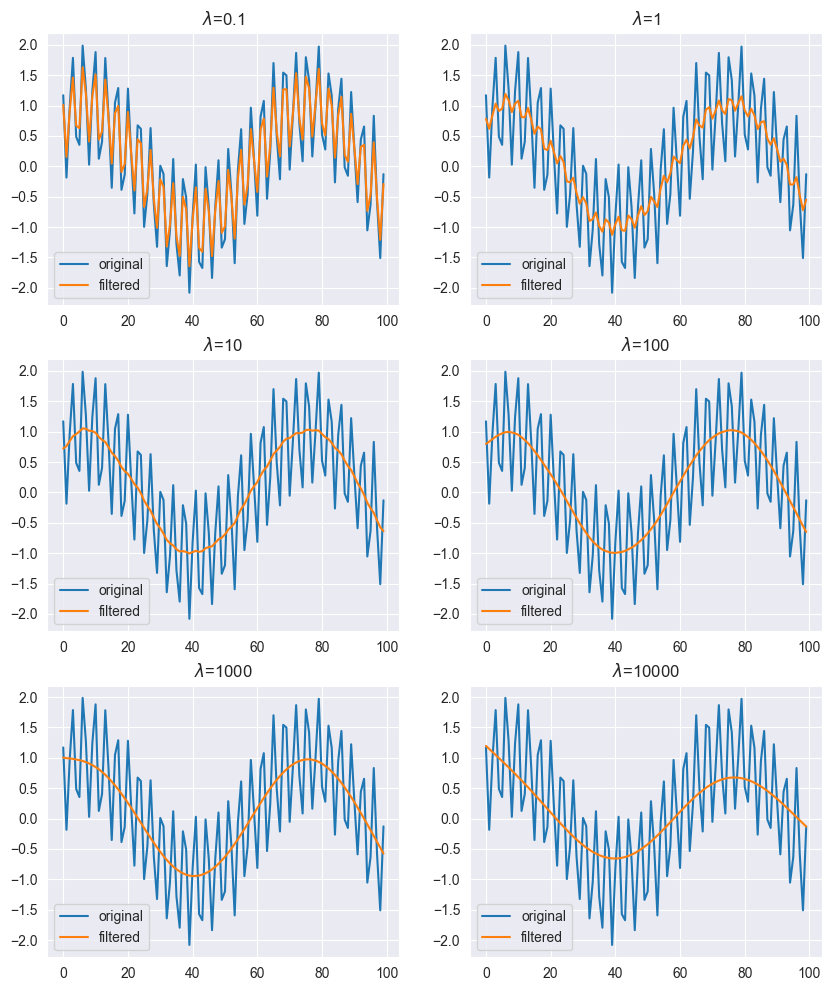

In [18]:
# 正则化参数影响 #
N = 100
t = np.linspace(1,10,N)
ts = np.sin(t) + np.cos(20*t) + np.random.randn(N)*0.1

plt.figure(figsize=(10,12))
for i,l in enumerate([0.1, 1, 10, 100, 1000, 10000]):
    plt.subplot(3,2,i+1)
    g = ts - extract_cycle(ts,l)
    plt.plot(ts, label='original')
    plt.plot(g, label='filtered')
    plt.legend()
    plt.title('$\lambda$='+str(l))
plt.show()

In [19]:
# 单边HP滤波 #
import math

def At(t: int, lam):
    e_t = np.zeros(t)
    e_t[-1] = 1
    I_t = np.identity(t - 2)

    Q_t = np.zeros((t - 2, t)) 
    for i in range(t - 2):
        Q_t[i, i], Q_t[i, i + 1], Q_t[i, i + 2] = 1, -2, 1

    A_t = np.matrix(e_t) @ Q_t.T @ (np.linalg.inv(Q_t @ Q_t.T + I_t / lam)) @ Q_t
    return A_t

def one_sided_HP_filter(df, lam):
    df_local = df.copy()
    data_series = np.array(df_local)  
    length = len(df)

    list_cycle = [math.nan, math.nan]  
    for i in range(2, length):
        #t=i+1
        sub_series = data_series[:i + 1] 
        sub_A_t = At(i + 1, lam)
        cycle_t = (sub_A_t @ sub_series)[0, 0]
        list_cycle.append(cycle_t)
    df_local['cycle_1sHP'] = list_cycle
    df_local['trend_1sHP'] = df[df.columns[0]] - np.array(list_cycle)
    return df_local

In [20]:
df_y1, df_y2 = one_sided_HP_filter(pd.DataFrame(y1), 129600), one_sided_HP_filter(pd.DataFrame(y2), 129600)
df_y1.head()

,000300.SH,cycle_1sHP,trend_1sHP
date,,,
20171201,3998.1365,NaN,NaN
20171204,4018.8571,NaN,NaN
20171205,4040.1704,0.098783,4040.071617
20171206,4015.8211,-13.580195,4029.401295
20171207,3971.0569,-26.312222,3997.369122


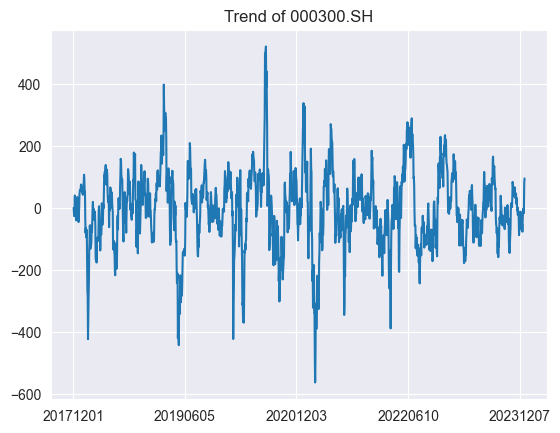

In [21]:
# 沪深300单边去趋势 #
plt.plot(df_y1.cycle_1sHP)
plt.title("Cycle of 000300.SH")
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(base=1))
plt.show()

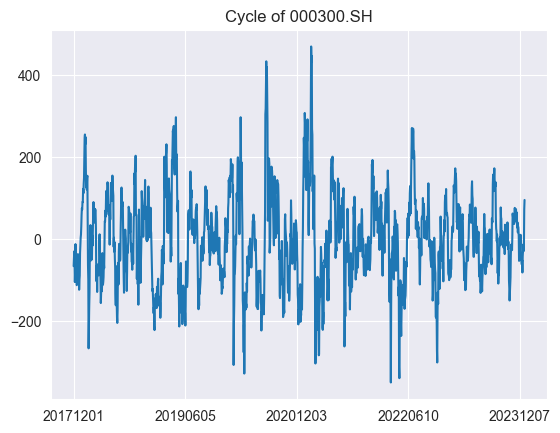

In [26]:
# 沪深300双边去趋势 #
plt.plot(cycle1)
plt.title("Cycle of 000300.SH")
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(base=1))
plt.show()

In [23]:
print("沪深300去趋势后单位根检验P值：", adfuller(cycle1)[1])
print("中证1000去趋势后单位根检验P值：", adfuller(cycle2)[1])

沪深300去趋势后单位根检验P值： 3.1831622033195e-16
中证1000去趋势后单位根检验P值： 2.7477628013182795e-15


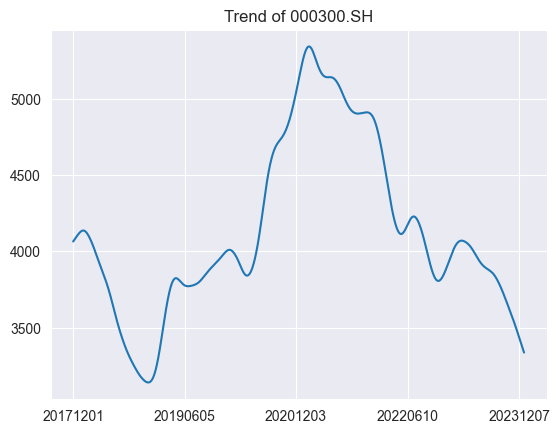

In [24]:
plt.plot(y1 - cycle1)
plt.title("Trend of 000300.SH")
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(base=1))
plt.show()

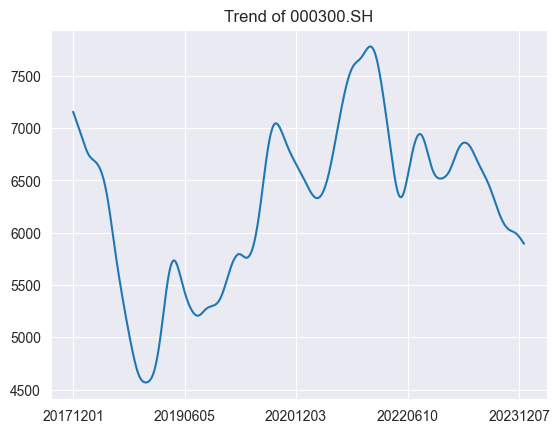

In [25]:
plt.plot(y2 - cycle2)
plt.title("Trend of 399852.SZ")
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(base=1))
plt.show()

In [27]:
coint(y1-cycle1, y2-cycle2)

(-1.5253957744481133,
 0.751325592882696,
 array([-3.90387033, -3.34026996, -3.04732274]))

(-2.2043392916787004, 0.2046743156833148, 3, 1210, {'1%': -3.4357658900670085, '5%': -2.8639315921664568, '10%': -2.5680433235434736}, 13261.404640157081)


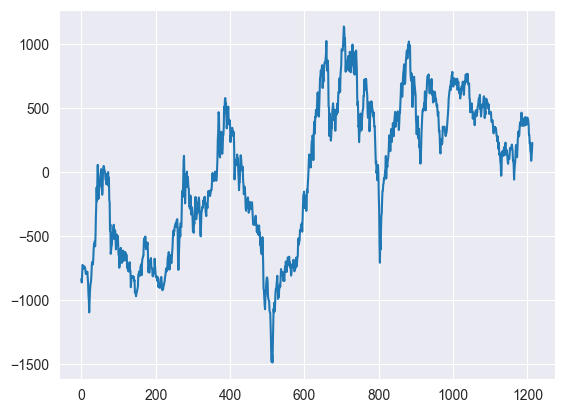

In [29]:
# 取后五年数据回归的残差项 #
X = df.loc['20190101':, '000300.SH'].to_numpy()
y = df.loc['20190101':, '399852.SZ'].to_numpy()
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
residuals = results.resid
print(adfuller(residuals))

plt.plot(residuals)
plt.show()

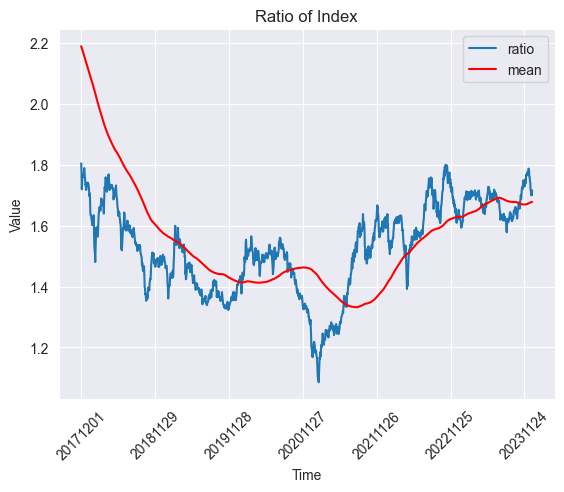

In [30]:
plt.plot(after.index, after['ratio'], label='ratio')
plt.plot(after.index, after['mean'], color='red', label='mean')
plt.xticks(after.index[::242], after.index[::242])
plt.xticks(rotation=45)
plt.title('Ratio of Index')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

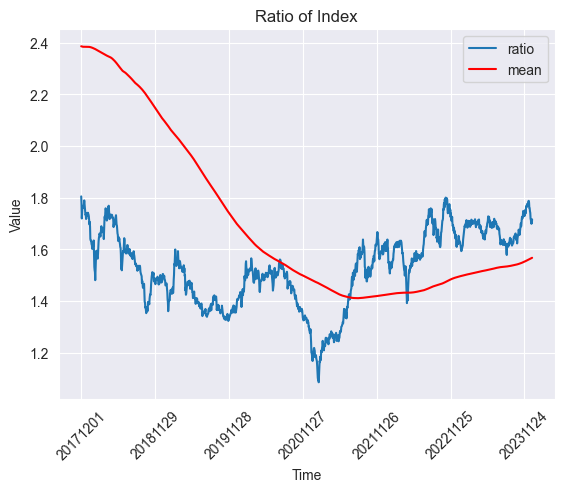

In [31]:
plt.plot(after.index, after['ratio'], label='ratio')
plt.plot(after.index, after['mean3'], color='red', label='mean')
plt.xticks(after.index[::242], after.index[::242])
plt.xticks(rotation=45)
plt.title('Ratio of Index')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

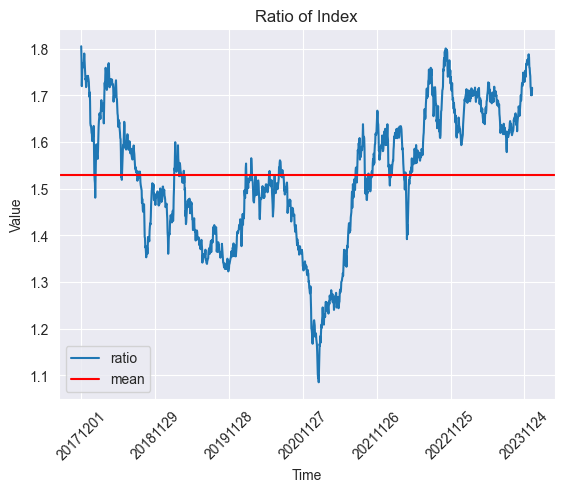

In [32]:
plt.plot(after.index, after['ratio'], label='ratio')
plt.axhline(after.ratio.mean(), color='red', label='mean')
plt.xticks(after.index[::242], after.index[::242])
plt.xticks(rotation=45)
plt.title('Ratio of Index')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

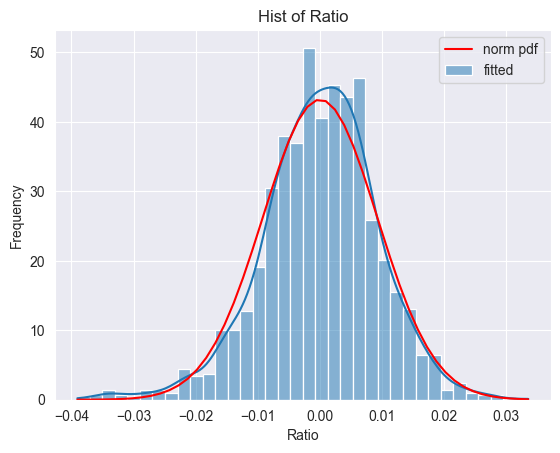

In [33]:
mu, std = norm.fit(after.rate)
x = np.linspace(after.rate.min(), after.rate.max(), 50)
norm_y = norm.pdf(x, mu, std)

sns.histplot(after.rate, stat="density", kde=True, label='fitted')
plt.plot(x, norm_y, label="norm pdf", color="red")
plt.title("Hist of Ratio")
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [34]:
tbl = pd.DataFrame(eda(after.rate), 
                   columns=['mean', 'std', 'skew', 'kurtosis', 'p_value'], 
                   index=['ratio'])
print(tbl)

           mean       std      skew  kurtosis  p_value
ratio  0.000016  0.009233 -0.357341  1.064016      0.0


In [37]:
df.loc['20190101':, ['000300.SH', '399852.SZ']].corr()

,000300.SH,399852.SZ
000300.SH,1.000000,0.665768
399852.SZ,0.665768,1.000000


In [36]:
result_coint = coint(df.loc['20190101':, '000300.SH'], df.loc['20190101':, '399852.SZ'])
print(result_coint[1])

0.8278402869848089


In [35]:
df.loc['20210101':, ['000300.SH', '399852.SZ']].corr()

,000300.SH,399852.SZ
000300.SH,1.000000,0.509317
399852.SZ,0.509317,1.000000


In [38]:
result_coint = coint(df.loc['20210101':, '000300.SH'], df.loc['20210101':, '399852.SZ'])
print(result_coint[1])

0.7340466824591978


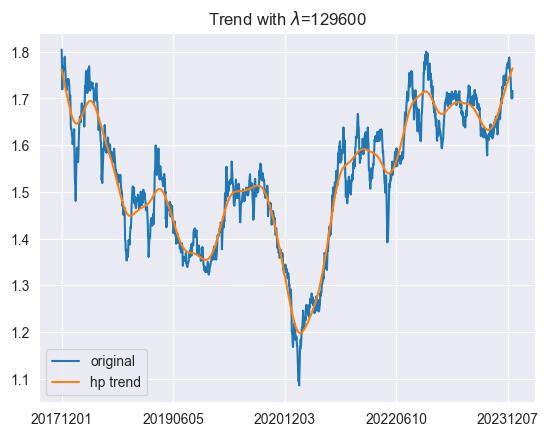

In [41]:
ratio = after.ratio
ratio_trend = ratio - extract_cycle(ratio, 129600)

plt.plot(ratio, label='original')
plt.plot(ratio_trend, label='hp trend')
plt.title('Trend with $\lambda$=' + str(129600))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(base=1))
plt.legend()
plt.show()